# MICROSOFT RESEARCH SENTENCE COMPLETION CHALLENGE¶

## Imports

In [1]:
!pip install Transformers

import sys
import operator
import csv
import pandas as pd, csv
import os, random, nltk

nltk.download("wordnet")
nltk.download("wordnet_ic")
nltk.download("lin_thesaurus")
from nltk.corpus import wordnet as wn, wordnet_ic as wn_ic, lin_thesaurus as lin
brown_ic = wn_ic.ic("ic-brown.dat")
import time
start_time = time.time()
from os.path import join, isfile
from os import listdir
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, AdamW
from tqdm.auto import tqdm

!pip install gensim
from gensim import corpora, models
from scipy import spatial

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rky42\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     C:\Users\rky42\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!
[nltk_data] Downloading package lin_thesaurus to
[nltk_data]     C:\Users\rky42\AppData\Roaming\nltk_data...
[nltk_data]   Package lin_thesaurus is already up-to-date!


# N-Gram Model

In [2]:
unigram = {}
bigram = {}
trigram = {}
quadrigram = {}

TRAINING_DIR = "/data/Holmes_Training_Data"
filenames=os.listdir(TRAINING_DIR) 
print(len(filenames))

522


In [3]:
index_of_found = []

In [4]:
for d in range(0, len(filenames)):
  try:
    doc = filenames[d]
    print(d)
    full_doc = ""
    with open(os.path.join(TRAINING_DIR, doc)) as instream:
      for line in instream:
        full_doc += line[:-1] + " "   # by removing the last 2 characters, we remove the \n characters from the end of every line.
    full_doc = full_doc.split(" ")
    tokens = ["__END","__START"]


    #Here we tokenise the entire document so it can be easily converted into an n-gram.
    #This is not the most efficient system, but i don't know how to do regex in python.
    for token in full_doc:
      word = token
      if len(word) > 0 and not word == "\"": #This ignores blank tokens as well as tokens that contain just speech marks
        if word[-1] == "\"": #we individually remove punctuation
          word = word[:-1]
        if word[0] == "\"": 
          word = word[1:]
        if word[-1] == "." or word[-1] == "!" or word[-1] == "?": #sentence enders need tokens added to end and start new sentences
          tokens.append(word[:-1])
          tokens.append(word[-1])
          tokens.append("__END")
          tokens.append("__START")
        elif word[-1] == "," or word[-1] == ";":
          tokens.append(word[:-1])
          tokens.append(word[-1])
        elif not word == "":
          tokens.append(word)

    
    #Here we construct the n-grams, creating sums of occurances for all documents
    for i in range(len(tokens)):
      unigram[tokens[i]] = unigram.get(tokens[i], 0) + 1
      if i < len(tokens) - 1:
        if not tokens[i] in bigram:
          bigram[tokens[i]] = {}
        bigram[tokens[i]][tokens[i+1]] = bigram[tokens[i]].get(tokens[i+1], 0) + 1
      if i < len(tokens) - 2:
        if not tokens[i] in trigram:
          trigram[tokens[i]] = {}
        if not tokens[i+1] in trigram[tokens[i]]:
          trigram[tokens[i]][tokens[i+1]] = {}
        trigram[tokens[i]][tokens[i+1]][tokens[i+2]] = trigram[tokens[i]][tokens[i+1]].get(tokens[i+2], 0) + 1
      if i < len(tokens) - 3:
        if not tokens[i] in quadrigram:
          quadrigram[tokens[i]] = {}
        if not tokens[i+1] in quadrigram[tokens[i]]:
          quadrigram[tokens[i]][tokens[i+1]] = {}
        if not tokens[i+2] in quadrigram[tokens[i]][tokens[i+1]]:
          quadrigram[tokens[i]][tokens[i+1]][tokens[i+2]] = {}
        quadrigram[tokens[i]][tokens[i+1]][tokens[i+2]][tokens[i+3]] = quadrigram[tokens[i]][tokens[i+1]][tokens[i+2]].get(tokens[i+3], 0) + 1
  except:
    print("error in file " + filenames[d])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [5]:
sum = 0
for x in unigram:
  sum += unigram[x]
for x in unigram:
  unigram[x] /= sum

for x in bigram:
  sum = 0
  for y in bigram[x]:
    sum += bigram[x][y]
  for y in bigram[x]:
    bigram[x][y] = bigram[x][y] / sum

for x in trigram:
  for y in trigram[x]:
    sum = 0
    for z in trigram[x][y]:
      sum += trigram[x][y][z]
    for z in trigram[x][y]:
      trigram[x][y][z] /= sum

for x in quadrigram:
  for y in quadrigram[x]:
    for z in quadrigram[x][y]:
      sum = 0
      for t in quadrigram[x][y][z]:
        sum += quadrigram[x][y][z][t]
      for t in quadrigram[x][y][z]:
        quadrigram[x][y][z][t] /= sum

In [6]:
questions=os.path.join("/data/testing_data.csv")
answers=os.path.join("/data/test_answer.csv")
with open(questions) as instream:
  csvreader=csv.reader(instream)
  lines=list(csvreader)
qs_df=pd.DataFrame(lines[1:],columns=lines[0])
qs_df.head()

,id,question,a),b),c),d),e)
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus


In [7]:
def get_left_context(sentence):
  sent = ["_END", "_START"] + sentence.split(" ")
  last = "_START"
  twolast = "_END"
  for i in range(2, len(sent)):
    if sent[i] == "_____":
      return sent[i-3], sent[i-2], sent[i-1]

results = []
for num in range(0, len(qs_df["question"])):
  sentence = qs_df["question"][num]
  options = []
  options.append(qs_df["a)"][num])
  options.append(qs_df["b)"][num])
  options.append(qs_df["c)"][num])
  options.append(qs_df["d)"][num])
  options.append(qs_df["e)"][num])
  guesses = []
  c1, c2, c3 = get_left_context(sentence)
  for option in options:
    try:
      guesses.append(quadrigram[c1][c2][c3][option])
    except:
      guesses.append(0)
  greater = False
  highest = 0
  res = ""
  if guesses[0] > highest:
    greater = True
    res = "a"
    highest = guesses[0]
  if guesses[1] > highest:
    greater = True
    res = "b"
    highest = guesses[1]
  if guesses[2] > highest:
    greater = True
    res = "c"
    highest = guesses[2]
  if guesses[3] > highest:
    greater = True
    res = "d"
    highest = guesses[3]
  if guesses[4] > highest:
    greater = True
    res = "e"
    highest = guesses[4]
  if greater == True:
    results.append(res)
    index_of_found.append(num)
  else:
    print("UNFOUND")
    results.append(random.choice(["a","b","c","d","e"]))

UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND
UNFOUND


In [8]:
with open(answers) as instream:
  csvreader=csv.reader(instream)
  lines=list(csvreader)
as_df=pd.DataFrame(lines[1:],columns=lines[0])
as_df.head()
answer_list = []
for x in as_df["answer"]:
  answer_list.append(x)

In [9]:
sum = 0
for x in index_of_found:
  if answer_list[x] == results[x]:
    sum += 1
print(sum / len(index_of_found))

## quadrigram given found. 44.65% accuracy

0.44654088050314467


<AxesSubplot:>

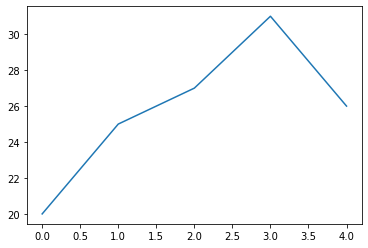

In [10]:
df = pd.DataFrame([20,25,27,31,26], index=[0, 1, 2, 3, 4])
df.plot(legend=False)

<AxesSubplot:>

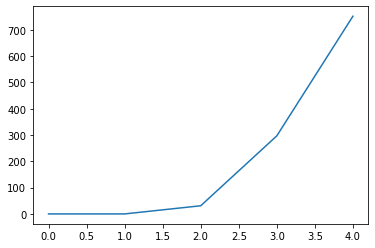

In [11]:
df = pd.DataFrame([0, 0, 31, 297, 752])
df.plot(legend=False)

## BERT Pre-Trained Model 

In [12]:
#Loading pre-trained models
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
def make_segment_ids(list_of_tokens):
  #this function assumes that up to and including the first '[SEP]' is the first segment, anything afterwards is the second segment
  current_id=0
  segment_ids=[]
  for token in list_of_tokens:
    segment_ids.append(current_id)
  return torch.tensor([segment_ids])

def tokeniseText(question):
  masked_index = 0 
  tokenized = ["[CLS]"] + tokenizer.tokenize(question)
  temp = []
  found = False
  for i, word in enumerate(tokenized):
    if word == "_" and found == False:
      if tokenized[i+4] == "_":
        masked_index = i
        temp.append("[MASK]")
        found = True            
    #this fixes the issue of underscores appearing later in the word.
    elif word == "_":
      pass
    else:
      temp.append(word)
  temp.append("[SEP]")


  segment_ids=make_segment_ids(temp)
  return torch.tensor([tokenizer.convert_tokens_to_ids(temp)]), masked_index, segment_ids

In [14]:
def predict(input_sentence):
  tokens_tensor, masked_index, segment_ids = tokeniseText(input_sentence)

  with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segment_ids)
    predictions = outputs[0]
        
  #find the token id which maximises the prediction for the masked token and then convert this back to a word
  predicted_index = torch.argmax(predictions[0, masked_index]).item()
  predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
  return predicted_token

In [15]:
def getMostLikelyFromPrediction(prediction, choices):
  best_word_path = ""
  best_sim_path = 0
  best_word_res = ""
  best_sim_res = 0
  best_word_lin = ""
  best_sim_lin = 0
  for x in choices:
    highest_sim_path = 0
    highest_sim_res = 0
    highest_sim_lin = 0
    for a in wn.synsets(prediction):
      for b in wn.synsets(x):
        temp_path = None
        temp_res = None
        temp_lin = None
        try:
          temp_path = wn.path_similarity(a, b)
          temp_res = wn.res_similarity(a, b, brown_ic)
          temp_lin = wn.lin_similarity(a, b, brown_ic)
        except:
          pass
        if not temp_path == None:
          if temp_path > highest_sim_path:
            highest_sim_path = temp_path

        if not temp_res == None:
          if temp_res > highest_sim_res:
            highest_sim_res = temp_res
        
        if not temp_lin == None:
          if temp_lin > highest_sim_lin:
            highest_sim_lin = temp_lin

    if highest_sim_path > best_sim_path:
      best_word_path = x
      best_sim_path = highest_sim_path

    if highest_sim_res > best_sim_res:
      best_word_res = x
      best_sim_res = highest_sim_res

    if highest_sim_lin > best_sim_lin:
      best_word_lin = x
      best_sim_lin = highest_sim_lin




  if best_word_path == "":
    n = random.randint(0,4)
  else:
    n = choices.index(best_word_path)
  if best_word_res == "":
    o = random.randint(0,4)
  else:
    o = choices.index(best_word_res)
  if best_word_lin == "":
    p = random.randint(0,4)
  else:
    p = choices.index(best_word_lin)

  letters = ["a","b","c","d","e"]
  return letters[n], letters[o], letters[p]

In [16]:
questions=os.path.join("/data/testing_data.csv")
answers=os.path.join("/data/test_answer.csv")
with open(questions) as instream:
  csvreader=csv.reader(instream)
  lines=list(csvreader)
qs_df=pd.DataFrame(lines[1:],columns=lines[0])
qs_df.head()
results_path = []
results_res = []
results_lin = []
for num in range(0, len(qs_df)):
  sentence = qs_df["question"][num]
  prediction = predict(sentence)
  print(prediction)
  letters = ["a)","b)","c)","d)","e)"]
  choices = []
  for x in letters:
    choices.append(qs_df[x][num])
  path, res, lin = getMostLikelyFromPrediction(prediction, choices)
  results_path.append(path)
  results_res.append(res)
  results_lin.append(lin)

with open(answers) as instream:
  csvreader=csv.reader(instream)
  lines=list(csvreader)
as_df=pd.DataFrame(lines[1:],columns=lines[0])
as_df.head()
answer_list = []
for x in as_df["answer"]:
  answer_list.append(x)

p_acc = 0
r_acc = 0
l_acc = 0
for i in range(0, len(qs_df)):
  if answer_list[i] == results_path[i]:
    p_acc += 1
  if answer_list[i] == results_res[i]:
    r_acc += 1
  if answer_list[i] == results_lin[i]:
    l_acc += 1
print("path accuracy = " + str(p_acc/len(answer_list)))
print("res accuracy  = " + str(r_acc/len(answer_list)))
print("lin accuracy  = " + str(l_acc/len(answer_list)))

##path = 42.69%
##res = 45.19%
##lin = 45.28%

living
neatly
king
paid
piece
heels
space
dark
odd
patiently
told
stars
dangerous
calls
musician
review
eager
got
others
tower
great
done
surprise
books
man
door
still
conspiracy
walked
study
good
life
top
fell
merchants
worst
changed
paper
counted
leaped
moving
report
steps
stay
appear
men
kept
answer
sight
down
going
carried
burden
handsome
blinked
through
shocked
held
pulled
jokes
come
carriage
hush
looked
have
god
darkness
work
man
rest
looked
sound
follow
bench
inquiries
financial
serious
stairs
section
exceed
somewhere
beautiful
growing
got
separate
missed
names
closed
gone
thought
interrupted
doors
tell
lover
cry
one
wrinkled
made
handle
swelled
closed
telling
life
rear
calling
enter
wool
gasped
revealed
wall
straightened
missed
gentleman
complaints
light
diplomat
give
spark
come
sheet
strong
actor
trapped
rested
see
help
twenty
stored
way
assassin
continue
permission
room
eyes
friends
tell
stranger
then
grim
drawer
interpreter
doubts
sort
urgency
deep
personal
old
man
taken
ter

<AxesSubplot:>

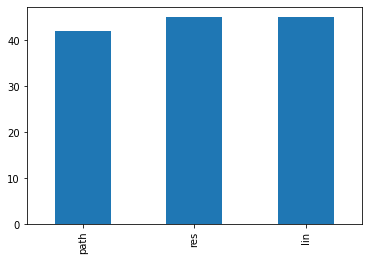

In [33]:
df = pd.DataFrame([42,45,45], index=["path","res","lin"])
df.plot.bar(legend=False)

## LSA Model

In [18]:
#Load dataset for LSA Model
books = []
mypath = "/data/Holmes_Training_Data"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
headerSeparator = "*END*THE SMALL PRINT! FOR PUBLIC DOMAIN ETEXTS*Ver.04.29.93*END*"
noOfFiles = 522
for fname in onlyfiles:
    fp = open(mypath + "/" + fname,"r",encoding='cp1252')
    bookContent = ""
    headerSeparatorDetected = False
    for line in fp.readlines():
        if not headerSeparatorDetected:
            if line.strip() == headerSeparator:
                headerSeparatorDetected = True
            continue
        line = line.strip()
        if not (len(line) == 0):
            bookContent = bookContent + " " + line.lower()
    books.append(bookContent)
    fp.close()
    noOfFiles = noOfFiles - 1
    if noOfFiles == 0:
        break

    print("No of sentences read",len(books))

No of sentences read 1
No of sentences read 2
No of sentences read 3
No of sentences read 4
No of sentences read 5
No of sentences read 6
No of sentences read 7
No of sentences read 8
No of sentences read 9
No of sentences read 10
No of sentences read 11
No of sentences read 12
No of sentences read 13
No of sentences read 14
No of sentences read 15
No of sentences read 16
No of sentences read 17
No of sentences read 18
No of sentences read 19
No of sentences read 20
No of sentences read 21
No of sentences read 22
No of sentences read 23
No of sentences read 24
No of sentences read 25
No of sentences read 26
No of sentences read 27
No of sentences read 28
No of sentences read 29
No of sentences read 30
No of sentences read 31
No of sentences read 32
No of sentences read 33
No of sentences read 34
No of sentences read 35
No of sentences read 36
No of sentences read 37
No of sentences read 38
No of sentences read 39
No of sentences read 40
No of sentences read 41
No of sentences read 42
N

No of sentences read 335
No of sentences read 336
No of sentences read 337
No of sentences read 338
No of sentences read 339
No of sentences read 340
No of sentences read 341
No of sentences read 342
No of sentences read 343
No of sentences read 344
No of sentences read 345
No of sentences read 346
No of sentences read 347
No of sentences read 348
No of sentences read 349
No of sentences read 350
No of sentences read 351
No of sentences read 352
No of sentences read 353
No of sentences read 354
No of sentences read 355
No of sentences read 356
No of sentences read 357
No of sentences read 358
No of sentences read 359
No of sentences read 360
No of sentences read 361
No of sentences read 362
No of sentences read 363
No of sentences read 364
No of sentences read 365
No of sentences read 366
No of sentences read 367
No of sentences read 368
No of sentences read 369
No of sentences read 370
No of sentences read 371
No of sentences read 372
No of sentences read 373
No of sentences read 374


In [19]:
stoplist = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'])
texts = [[word for word in book.split() if word not in stoplist] for book in books]

In [20]:
#Create a dictionary of the text corpus
dictionary = corpora.Dictionary(texts)
dictionary.save('deerwester.dict')

In [21]:
#Create bag of words
corpus = [dictionary.doc2bow(text) for text in texts]

In [22]:
corpora.MmCorpus.serialize('deerwester.mm', corpus)
corpus = corpora.MmCorpus('deerwester.mm') 
dictionary = corpora.Dictionary.load('deerwester.dict')

In [23]:
#Create TFIDF matrix
tfidf = models.TfidfModel(corpus) 
corpus_tfidf = tfidf[corpus]

In [24]:
#Create LSI model of the TFIDF matrix
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=20) 
corpus_lsi = lsi[corpus_tfidf] 
lsi.save('model.lsi') 

In [25]:
lsi = models.LsiModel.load('model.lsi')

In [26]:
testing_data_FN = "/data/testing_data.csv"
testing_data_answer_FN = "/data/test_answer.csv"

class QuestionProcessor:
    def __init__(self):
        self.questionSet = {}
        self.loadQuestion()

    def loadQuestion(self):
        with open(testing_data_FN,'r') as csvfile:
            qReader = csv.reader(csvfile,delimiter=',',quotechar='"')
            isHeader = True
            for row in qReader:
                if isHeader:
                    isHeader = False
                    continue
                q = Question()
                q.qNo = int(row[0])
                q.question = row[1]
                q.options["a"] = row[2]
                q.options["b"] = row[3]
                q.options["c"] = row[4]
                q.options["d"] = row[5]
                q.options["e"] = row[6]
                self.questionSet[q.qNo] = q
        with open(testing_data_answer_FN,'r') as csvfile:
            aReader = csv.reader(csvfile,delimiter=',',quotechar='"')
            isHeader = True
            for row in aReader:
                if isHeader:
                    isHeader = False
                    continue
                qNo = int(row[0])
                answer = row[1]
                self.questionSet[qNo].answer = answer

class Question:
    def __init__(self):
        self.qNo = None
        self.question = ""
        self.options = {"a":None,"b":None,"c":None,"d":None,"e":None}
        self.answer = ""
    def __repr__(self):
        return self.question

In [27]:
qp = QuestionProcessor()

In [28]:
from nltk.tokenize import word_tokenize

def getPositionOfBlank(question):
    qToken = word_tokenize(question.lower())
    index = 0
    for token in qToken:
        if token == "_____":
            return index
            break
        index += 1
    return -1

In [29]:
def getAnswer(q):
    blankPos = getPositionOfBlank(q.question)
    #print(blankPos)
    stoplist.add("_____")
    qsTokens = [word for word in q.question.split() if word not in stoplist]
#    print(qsTokens)
    qs_vectors = []
    for tokens in qsTokens:
        qs_bow = dictionary.doc2bow(tokens.lower().split())
        qs_tfidf = tfidf[qs_bow]
        qs_lsi = lsi[qs_tfidf]
        qs_vectors.append(qs_lsi)

    optToInd = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4}
    IndToOpt = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e'}
    options_vectors = [[] for i in range(5)]

    for key,option in q.options.items():
        option_bow = dictionary.doc2bow(option.lower().split())
        option_tfidf = tfidf[option_bow]
        option_lsi = lsi[option_tfidf]
        options_vectors[optToInd[key]] =  option_lsi

    qs_features = []
    option_features = []
    qs_features = [[tup[1] for tup in qsVec] for qsVec in qs_vectors if len(qsVec) > 0]
    option_features = [[tup[1] for tup in opVec] for opVec in options_vectors if len(opVec) > 0]

    resultForQues = {}
    for i in range(len(option_features)):
        resultForOpt = 0
        for j in range(len(qs_features)):
            resultForOpt += 1 - spatial.distance.cosine(qs_features[j], option_features[i])
        resultForQues[IndToOpt[i]] = resultForOpt
    ans = max(resultForQues.items(), key=operator.itemgetter(1))[0]
    return ans

In [30]:
def runTest():
    correct = 0
    total = 0
    for qNo in range(1,1041):
        q = qp.questionSet[qNo]
        ans = getAnswer(q)
        if ans:
            total += 1
            if q.answer == ans:
                correct += 1
            print(qNo, ans, q.answer, correct,correct/total)
    print("Achieved Accuracy with LSA",correct*100/total)

In [31]:
if __name__ == '__main__':
    if 'runTest' in sys.argv:
        runTest()
    else:
        print("Usage: python3 model.py runTest")

Usage: python3 model.py runTest


In [32]:
runTest()

1 e c 0 0.0
2 e a 0 0.0
3 b d 0 0.0
4 a c 0 0.0
5 d d 1 0.2
6 e b 1 0.16666666666666666
7 c b 1 0.14285714285714285
8 c c 2 0.25
9 c c 3 0.3333333333333333
10 a a 4 0.4
11 d b 4 0.36363636363636365
12 b b 5 0.4166666666666667
13 b d 5 0.38461538461538464
14 c e 5 0.35714285714285715
15 b c 5 0.3333333333333333
16 a c 5 0.3125
17 e e 6 0.35294117647058826
18 b a 6 0.3333333333333333
19 b e 6 0.3157894736842105
20 e c 6 0.3
21 b d 6 0.2857142857142857
22 d a 6 0.2727272727272727
23 e d 6 0.2608695652173913
24 c c 7 0.2916666666666667
25 b d 7 0.28
26 e b 7 0.2692307692307692
27 e d 7 0.25925925925925924
28 e c 7 0.25
29 d d 8 0.27586206896551724
30 c d 8 0.26666666666666666
31 e d 8 0.25806451612903225
32 e d 8 0.25
33 d c 8 0.24242424242424243
34 d a 8 0.23529411764705882
35 e e 9 0.2571428571428571
36 d c 9 0.25
37 d d 10 0.2702702702702703
38 d c 10 0.2631578947368421
39 b e 10 0.2564102564102564
40 a a 11 0.275
41 c d 11 0.2682926829268293
42 c c 12 0.2857142857142857
43 e e 13 0.302

297 c a 94 0.3164983164983165
298 b b 95 0.3187919463087248
299 c c 96 0.3210702341137124
300 c a 96 0.32
301 e a 96 0.31893687707641194
302 d a 96 0.31788079470198677
303 a c 96 0.31683168316831684
304 b b 97 0.3190789473684211
305 c e 97 0.3180327868852459
306 c e 97 0.31699346405228757
307 d a 97 0.31596091205211724
308 c a 97 0.31493506493506496
309 b b 98 0.31715210355987056
310 b a 98 0.3161290322580645
311 c a 98 0.31511254019292606
312 a c 98 0.3141025641025641
313 d e 98 0.31309904153354634
314 d e 98 0.31210191082802546
315 c c 99 0.3142857142857143
316 e e 100 0.31645569620253167
317 c e 100 0.31545741324921134
318 a a 101 0.31761006289308175
319 d c 101 0.3166144200626959
320 b b 102 0.31875
321 d c 102 0.3177570093457944
322 d d 103 0.3198757763975155
323 c b 103 0.3188854489164087
324 e b 103 0.31790123456790126
325 e c 103 0.3169230769230769
326 c a 103 0.3159509202453988
327 e b 103 0.3149847094801223
328 c e 103 0.31402439024390244
329 e e 104 0.3161094224924012
330 b 

596 c a 202 0.3389261744966443
597 b c 202 0.33835845896147404
598 b a 202 0.3377926421404682
599 e d 202 0.337228714524207
600 a b 202 0.33666666666666667
601 a b 202 0.33610648918469216
602 b c 202 0.33554817275747506
603 c e 202 0.33499170812603646
604 b a 202 0.3344370860927152
605 a e 202 0.3338842975206612
606 d d 203 0.334983498349835
607 e e 204 0.33607907742998355
608 a a 205 0.3371710526315789
609 a a 206 0.33825944170771755
610 a e 206 0.3377049180327869
611 c e 206 0.337152209492635
612 b a 206 0.3366013071895425
613 a c 206 0.3360522022838499
614 b b 207 0.33713355048859933
615 c e 207 0.33658536585365856
616 a e 207 0.336038961038961
617 d b 207 0.3354943273905997
618 e c 207 0.33495145631067963
619 d d 208 0.3360258481421648
620 a a 209 0.3370967741935484
621 a d 209 0.3365539452495974
622 e e 210 0.33762057877813506
623 c d 210 0.33707865168539325
624 b a 210 0.33653846153846156
625 b b 211 0.3376
626 c e 211 0.33706070287539935
627 b d 211 0.3365231259968102
628 c c 21

872 d d 285 0.3268348623853211
873 d b 285 0.32646048109965636
874 c c 286 0.32723112128146453
875 e d 286 0.32685714285714285
876 b e 286 0.3264840182648402
877 a a 287 0.3272519954389966
878 a c 287 0.32687927107061504
879 a b 287 0.3265073947667804
880 e b 287 0.3261363636363636
881 c b 287 0.3257661748013621
882 d e 287 0.3253968253968254
883 e c 287 0.3250283125707814
884 e d 287 0.3246606334841629
885 c e 287 0.32429378531073444
886 e b 287 0.3239277652370203
887 e a 287 0.32356257046223225
888 a c 287 0.32319819819819817
889 e a 287 0.3228346456692913
890 b b 288 0.3235955056179775
891 d d 289 0.32435465768799104
892 b b 290 0.3251121076233184
893 a b 290 0.3247480403135498
894 c a 290 0.3243847874720358
895 d d 291 0.32513966480446926
896 a a 292 0.32589285714285715
897 a e 292 0.3255295429208473
898 e b 292 0.32516703786191536
899 c d 292 0.3248053392658509
900 c b 292 0.3244444444444444
901 e e 293 0.32519422863485015
902 c c 294 0.3259423503325942
903 a e 294 0.3255813953488